# *Solving PDE using various finite difference methods*

Consider the following PDE


\begin{align}
\frac{\partial V}{\partial t}&=\frac{\tilde{\sigma}^2(t,x) x^2}{2}\frac{\partial^2 V}{\partial x^2} + rx\frac{\partial V}{\partial x} -rV,& t>0 \\
V(0,s)&=g(x),& t=0
\end{align}


where we have
\begin{align}
\tilde{\sigma}(t,x) = \sigma(T-t,x) = \left(1+\frac{T-t}{30}\right)\left[0.1 + 0.4\exp\left(-\frac{s}{50}\right)\right]
\end{align}

In [49]:
import numpy as np
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt


K, r, T = 100, 0.01, 1

*Grid specification*

In [50]:
#Specify grid parameters and set up grids
x_min, x_max = 10, 300
N, M = 1000, 200  
dt = T/N
dx = (x_max - x_min)/M
x = np.linspace(x_min, x_max, M+1)
t = np.linspace(0, T, N+1)

In [48]:
dx**2

2.1025

# *Explicit scheme*


Let
\begin{align}
a^n_k := a(t_n, x_k) = \frac{\tilde{\sigma}^2(t_n,x_k)x_k^2}{2},\qquad b^n_k := rx_k
\end{align}


Under explicit scheme, we can discretise the above PDE as

\begin{align*}
\frac{V^{n+1}_k-V^n_{k}}{\triangle t}&=a^n_k\frac{V^{n}_{k+1}-2V^n_k+V^n_{k-1}}{\triangle x^2}
+b^n_k \frac{V^{n}_{k+1}-V^n_{k-1}}{2\triangle x}-r V^n_k \\
\implies \quad V^{n+1}_k&=\left(a^n_k\frac{\triangle t}{\triangle x^2}-b^n_k\frac{\triangle t}{2\triangle x}\right)V^{n}_{k-1}+\left(1-2a^n_k\frac{ \triangle t}{\triangle x^2}-r\triangle t \right)V^n_k\\
&\qquad +\left(a^n_k\frac{\triangle t}{\triangle x^2}+b^n_k\frac{\triangle t}{2\triangle x}\right)V^{n}_{k+1}\\
&=A^n_k V^n_{k-1} +(1+B^n_k) V^n_{k}+C^n_k V^n_{k+1}
\end{align*}
for $k=1, 2, ..., M-1$, where
\begin{align}
A^n_k:=a^n_k\frac{\triangle t}{\triangle x^2}-b^n_k\frac{\triangle t}{2\triangle x},\qquad B^n_k:=-2a^n_k\frac{ \triangle t}{\triangle x^2}-r\triangle t ,\qquad C^n_k:=a^n_k\frac{\triangle t}{\triangle x^2}+b^n_k\frac{\triangle t}{2\triangle x}
\end{align}

In [51]:
# Set up the vectors A, B and C, note that A, B and C are time-dependent
def tilde_sigma(t,T,x):
    return (1+ (T-t)/30) * (0.1 + 0.4* np.exp(-x/50))

#set up a matrix for a^n_k, with each column corresponding to each time step
a = np.array([0.5* tilde_sigma(t,T,xx)**2 * xx**2 for xx in x])
b = r * x
A = a * dt / dx**2  - 0.5 * b[:, None] * dt/ dx
B = -2 * a * dt / dx**2 * - r * dt
C = a * dt / dx**2  + 0.5 * b[:, None] * dt/ dx

In [60]:
[tilde_sigma(t,T,xx) for xx in x]

[array([0.44174204, 0.44172779, 0.44171355, ..., 0.4275208 , 0.42750655,
        0.4274923 ]),
 array([0.43206913, 0.43205519, 0.43204125, ..., 0.41815929, 0.41814535,
        0.41813141]),
 array([0.4226727 , 0.42265906, 0.42264543, ..., 0.40906536, 0.40905173,
        0.40903809]),
 array([0.41354485, 0.41353151, 0.41351817, ..., 0.40023137, 0.40021803,
        0.40020469]),
 array([0.40467791, 0.40466485, 0.4046518 , ..., 0.39164989, 0.39163683,
        0.39162378]),
 array([0.39606441, 0.39605164, 0.39603886, ..., 0.38331369, 0.38330092,
        0.38328814]),
 array([0.38769712, 0.38768462, 0.38767211, ..., 0.37521578, 0.37520327,
        0.37519076]),
 array([0.379569  , 0.37955676, 0.37954451, ..., 0.36734933, 0.36733708,
        0.36732484]),
 array([0.37167321, 0.37166122, 0.37164923, ..., 0.35970773, 0.35969574,
        0.35968375]),
 array([0.36400311, 0.36399136, 0.36397962, ..., 0.35228456, 0.35227281,
        0.35226107]),
 array([0.35655224, 0.35654074, 0.35652924, ..., 0

The matrix L is also time dependent, so we create a 3-D array to hold L at each time step. Note that we choose $n = 0,1,\ldots, N-1$.

In [52]:
# Setup the array L^n 

a_diag = np.array([np.concatenate([A[1:-1,j],[0]]) for j in range(N+1)])
b_diag = np.array([np.concatenate([[0],B[1:-1,j],[0]]) for j in range(N+1)])
c_diag = np.array([np.concatenate([[0],C[1:-1,j]]) for j in range(N+1)])

L = np.zeros((N+1, M+1, M+1))
for i in range(N+1):  
    L[i,:,:] = diags([a_diag[i,:], b_diag[i,:], c_diag[i,:]], [-1, 0, 1]).toarray()
I = np.identity(M+1)

In [56]:
I+L[10,:,:]

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00577714, 1.00000012, 0.00585611, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.007021  , 1.00000014, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.00000457, 0.22975213,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.22979896, 1.00000462,
        0.23185793],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

The complete recursive algorithm is: 
\begin{align}
V^{n+1}=B^{n+1}((\mathbb{I}+L^n) V^{n})
\end{align}
where $n = 0,1,\ldots,N-1$, and $B^{n+1}(\cdot)$ is an operator which overwrites the first and last entry of the input vector to $\ell^{n+1}_0:=\ell(t_{n+1},x_0)$ and $u^{n+1}_{M}:=u(t_{n+1},x_M)$.

In [61]:
# Initial condition
v_ex = np.maximum(x - K, 0) # call option payoff

# Iteration of explicit scheme
for n in range(N):
    v_ex = np.matmul(I+L[n,:,:], v_ex)           # V^{n+1} = (I+L)V^n
    v_ex[0] = 0                           # Boundary operation at x_min
    v_ex[M] = x_max - K*np.exp(-r*t[n+1])   # Boundary operation at x_max

In [62]:
v_ex

array([0.00000000e+000, 2.37387938e+019, 5.65091132e+020, 1.20882589e+022,
       2.67621844e+023, 6.98218103e+024, 2.10893782e+026, 6.57146273e+027,
       1.95111918e+029, 5.36417764e+030, 1.35907911e+032, 3.18336287e+033,
       6.92943225e+034, 1.40938343e+036, 2.69203617e+037, 4.85127323e+038,
       8.28255996e+039, 1.34476019e+041, 2.08343645e+042, 3.08971920e+043,
       4.39834595e+044, 6.02577924e+045, 7.96374677e+046, 1.01752251e+048,
       1.25938511e+049, 1.51271700e+050, 1.76634564e+051, 2.00812221e+052,
       2.22600919e+053, 2.40915566e+054, 2.54882110e+055, 2.63904145e+056,
       2.67697717e+057, 2.66293300e+058, 2.60008346e+059, 2.49397060e+060,
       2.35185813e+061, 2.18202927e+062, 1.99310640e+063, 1.79345350e+064,
       1.59070148e+065, 1.39141486e+066, 1.20090026e+067, 1.02314262e+068,
       8.60846305e+068, 7.15553649e+069, 5.87813296e+070, 4.77373297e+071,
       3.83378211e+072, 3.04554702e+073, 2.39375315e+074, 1.86194746e+075,
       1.43356756e+076, 1

# *Fully implicit scheme*

Under the fully implicit scheme, we have
\begin{align*}
 V^{n-1}_k=-A^n_k V^n_{k-1} +(1-B^n_k) V^n_{k}-C^n_k V^n_{k+1}
\end{align*}
for $k=1, 2, ..., M-1$, $n = 1,2,\ldots,N$, where
\begin{align}
A^n_k:=a^n_k\frac{\triangle t}{\triangle x^2}-b^n_k\frac{\triangle t}{2\triangle x},\qquad B^n_k:=-2a^n_k\frac{ \triangle t}{\triangle x^2}-r\triangle t ,\qquad C^n_k:=a^n_k\frac{\triangle t}{\triangle x^2}+b^n_k\frac{\triangle t}{2\triangle x}
\end{align}


The complete recursive algorithm is: 
\begin{align}

(\mathbb{I}-L^{n})V^{n}=B^{n}(V^{n-1}).

\end{align}
where $n = 1,\ldots,N$.

In the fully implicit scheme, we need to make use of the Thomas algorithm to solve the system of equations

In [9]:
# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [10]:
# Initial condition
v_im = np.maximum(x - K, 0)

# Iteration of implicit scheme
for n in range(1,N+1):
    
    d = v_im   # The RHS of the system of equations is V^{n-1}
    d[0] = 0   # Boundary operator at x_min
    d[M] = x_max - K*np.exp(-r*t[n])  # Boundary operator at x_max
    v_im = TDMAsolver(-a_diag[n,:], 1-b_diag[n,:], -c_diag[n,:], d)   # Run the Thomas algorithm to solve for V^n

# *Crank-Nicolson scheme*

The general $\theta$-scheme is: 
\begin{align}

(\mathbb{I}-\theta L^{n})V^{n}=B^{n}[(\mathbb{I} + (1-\theta)L^{n-1})V^{n-1})]

\end{align}
where $n = 1,\ldots,N$.

The choice of $\theta = \frac 1 2$ is the Crank-Nicolson scheme, i.e

\begin{align}

(\mathbb{I}-\frac 1 2 L^{n})V^{n}=B^{n}[(\mathbb{I} +\frac 1 2L^{n-1})V^{n-1})]

\end{align}


In [12]:
# Initial condition
v_cn = np.maximum(x - K, 0)

# Iteration of implicit scheme
for n in range(1,N+1):
    
    d = np.matmul(I+ 0.5* L[n-1,:,:], v_cn)  # The RHS of the system of equations is V^{n-1}
    d[0] = 0   # Boundary operator at x_min
    d[M] = x_max - K*np.exp(-r*t[n])  # Boundary operator at x_max
    v_cn = TDMAsolver(-0.5*a_diag[n,:], 1-0.5*b_diag[n,:], -0.5*c_diag[n,:], d)   # Run the Thomas algorithm to solve for V^n

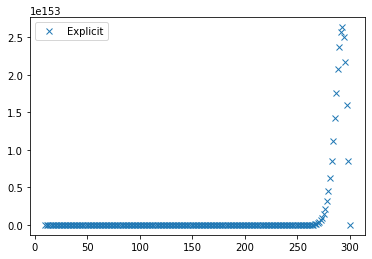

In [16]:
fig, ax = plt.subplots()
#ax.plot(x, v_cn, 'k-', label="Crank-Nicolson")
#ax.plot(x, v_im, '.',  label="Fully implicit")
ax.plot(x, v_ex, 'x',  label="Explicit")
ax.legend()